<h1 align="center" style="margin: 0; font-size: 36px;">Neural and Evolutionary Learning</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Project partial deliverable 4 (NN)</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Requirements
-  Fit a NN to the project dataset, including the hyperparameter tuning phase.
- Discuss th, overfitting, and premature convergence on the algorithm.
- Include your own insights and summary conclusionr>

### Table of Contents
[Imports](#chapter_1) <br>
[Settings](#chapter_2) <br>
[Load Data](#chapter_3) <br>
[Data Understanding](#chapter_4) <br>
[Data Preprocessing](#chapter_5) <br>
[Cross-Validation](#chapter_6) <br>
[Neural Network](#chapter_7) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Problem Instance Definition](#subchapter_7_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Functions](#subchapter_7_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution Graphs](#subchapter_7_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Variation of RMSE across Models](#subchapter_7_3_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Train vs Test Fitness ](#subchapter_7_3_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness Diversity](#s4bchapter_7_3_5) <br>
[To Evaluate](#chapter_8) <br>

<a id="chapter_1"></a>
## Imports


In [1]:
import os
import random
import copy
import pickle
import datetime
from itertools import product
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Statistical tests
from scipy.stats import spearmanr, shapiro

from slim_gsgp.datasets.data_loader import *
import joblib
from tqdm import tqdm

<a id="chapter_2"></a>
## Settings

In [2]:
seed = 43
np.random.seed(seed)
random.seed(seed)

In [3]:
train_color = 'blue'
test_color = 'orange'
size_color = 'green'

<a id="chapter_3"></a>
## Load Data

In [4]:
# Load Excel file
df = pd.read_excel("sustavianfeed.xlsx")

In [5]:
df

WING TAG  WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
0      G403  2223.3              1429.6                             1725.6   
1      G439  2201.9              1450.2                             1769.8   
2      G454  2159.9              1398.4                             1724.9   
3      G465  2198.7              1473.9                             1800.4   
4      G428  2003.2              1291.2                             1581.6   
..      ...     ...                 ...                                ...   
91     V476  2633.1              1683.2                             2034.1   
92     V454  2346.2              1547.8                             1819.5   
93     V425  2648.2              1722.9                             2050.0   
94     V490  2262.6              1498.5                             1813.9   
95     V428  2704.3              1698.8                             2038.8   

    COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)  SPLEEN   LIVER  \
0                1394.0              214.0             489.4   3.716  38.636   
1                1405.4              236.0             538.7   3.494  34.725   
2                1461.7              241.8             512.1   4.023  31.932   
3                1425.1              227.7             549.9   3.087  32.326   
4                1260.1              224.7             473.2   3.723  30.105   
..                  ...                ...               ...     ...     ...   
91               1637.2              213.8             610.9   4.777  45.992   
92               1511.2              228.0             528.2   3.673  35.090   
93               1669.8              253.1             610.0   5.176  50.505   
94               1468.0              212.1             548.4   2.829  30.266   
95               1655.6              245.7             606.9   5.960  40.922   

     HEART  INTESTINE EMPTY MUSCULAR STOMACH  GLANDULAR STOMACH  \
0    9.305    123.171                      /             13.170   
1   10.084     71.800                 45.273              9.781   
2   10.635     61.380                      /              6.217   
3   11.927     64.879                 35.861              8.358   
4    9.855     68.562                 36.526              7.572   
..     ...        ...                    ...                ...   
91  12.796     74.888                 54.021              7.857   
92  11.504     68.455                 42.173              7.837   
93  17.194     81.502                   49.7              7.332   
94  11.129     53.011                 46.816              5.425   
95  16.190     72.783                 75.767              7.420   

    CRUDE PROTEIN  ETHER EXTRACT  
0       86.105469           0.38  
1       86.143472           1.66  
2       86.416898           0.98  
3       85.959935           1.10  
4       81.693637           6.34  
..            ...            ...  
91      88.999126           1.07  
92      88.507288           1.13  
93      90.375587           1.91  
94      91.211353           2.21  
95      88.825045           1.51  

[96 rows x 15 columns]

In [6]:
# Droping ID column
df.drop(columns=['WING TAG'], inplace=True)

<a id="chapter_4"></a>
## Data Understanding

In [7]:
df.describe()

WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
count    96.000000           96.000000                          96.000000   
mean   2339.682292         1521.955208                        1833.378125   
std     200.943424          144.126939                         154.000550   
min    1968.400000         1284.900000                        1554.400000   
25%    2201.775000         1425.775000                        1723.800000   
50%    2299.500000         1493.050000                        1809.400000   
75%    2473.800000         1608.400000                        1922.725000   
max    2890.500000         1929.400000                        2262.800000   

       COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)     SPLEEN  \
count            96.000000          96.000000         96.000000  96.000000   
mean           1481.479167         234.116667        542.205208   4.219917   
std             142.830115          37.818405         60.994468   0.998836   
min            1252.600000         177.100000        177.800000   2.464000   
25%            1380.825000         218.775000        508.225000   3.534250   
50%            1452.800000         231.550000        538.100000   4.048000   
75%            1573.700000         243.275000        573.850000   4.817000   
max            1891.700000         533.200000        690.600000   7.758000   

           LIVER      HEART   INTESTINE  GLANDULAR STOMACH  CRUDE PROTEIN  \
count  96.000000  96.000000   96.000000          96.000000      96.000000   
mean   36.781427  12.059240   69.149156           8.184677      87.313708   
std     5.438894   1.932239   11.727467           1.697425       2.043895   
min    25.916000   8.561000   44.133000           5.425000      73.837184   
25%    33.053000  10.584250   62.274250           7.012750      86.544416   
50%    35.936000  11.679000   68.019500           7.809500      87.574947   
75%    40.485000  13.449750   75.103000           9.016750      88.508026   
max    53.133000  17.194000  123.171000          13.170000      91.211353   

       ETHER EXTRACT  
count      96.000000  
mean        2.090417  
std         1.351645  
min         0.320000  
25%         1.130000  
50%         1.710000  
75%         2.527500  
max         6.680000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WEIGHT                             96 non-null     float64
 1   HOT CARCASS WEIGHT                 96 non-null     float64
 2   CARCASS WEIGHT WITH HEAD AND LEGS  96 non-null     float64
 3   COLD CARCASS WEIGHT                96 non-null     float64
 4   BREAST WEIGHT (2)                  96 non-null     float64
 5   THIGH WEIGHT (2)                   96 non-null     float64
 6   SPLEEN                             96 non-null     float64
 7   LIVER                              96 non-null     float64
 8   HEART                              96 non-null     float64
 9   INTESTINE                          96 non-null     float64
 10  EMPTY MUSCULAR STOMACH             96 non-null     object 
 11  GLANDULAR STOMACH                  96 non-null     float64
 

> The column 'EMPTY MUSCULAR STOMACH' has been read as type object, possibly because some entries contain non-numeric or unexpected values, preventing it from being interpreted as float

In [9]:
df['EMPTY MUSCULAR STOMACH'].value_counts()

EMPTY MUSCULAR STOMACH
/         5
75.767    2
47.964    1
51.322    1
59.583    1
         ..
63.571    1
49.648    1
43.586    1
53.456    1
46.816    1
Name: count, Length: 91, dtype: int64

> The 'EMPTY MUSCULAR STOMACH' as 5 values '/'

In [10]:
# Coverting the column to numeric, forcing '/' to became Nan
df['EMPTY MUSCULAR STOMACH'] = pd.to_numeric(df['EMPTY MUSCULAR STOMACH'], errors='coerce')

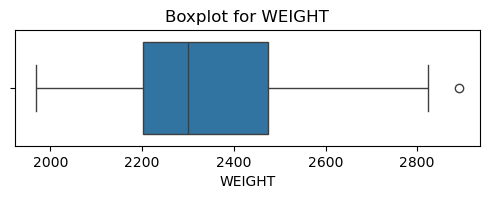

WEIGHT — Outliers detected: 1


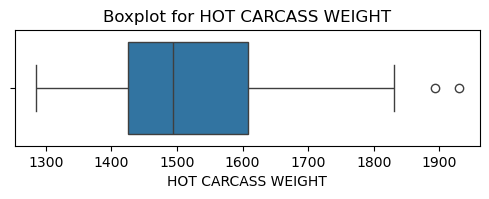

HOT CARCASS WEIGHT — Outliers detected: 2


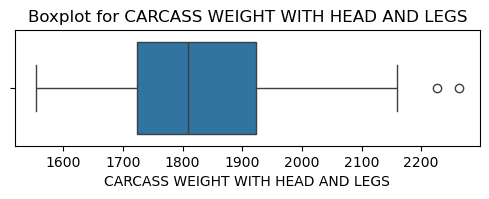

CARCASS WEIGHT WITH HEAD AND LEGS — Outliers detected: 2


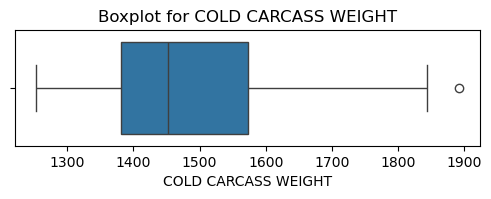

COLD CARCASS WEIGHT — Outliers detected: 1


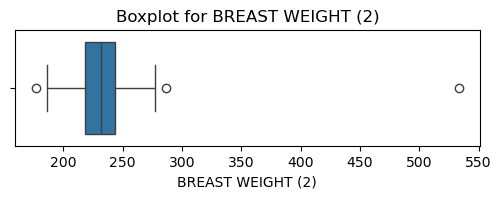

BREAST WEIGHT (2) — Outliers detected: 3


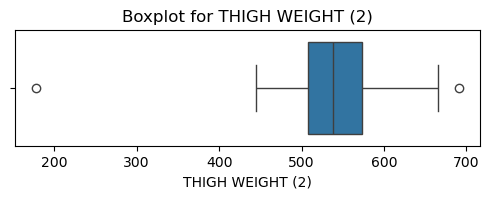

THIGH WEIGHT (2) — Outliers detected: 2


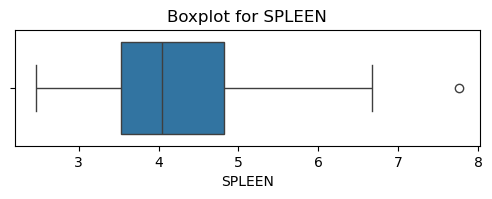

SPLEEN — Outliers detected: 1


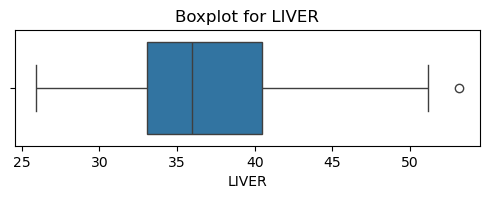

LIVER — Outliers detected: 1


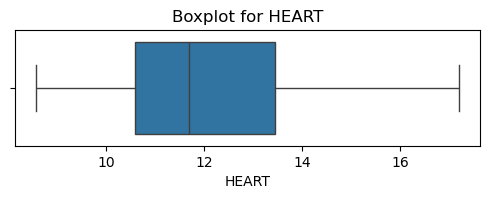

HEART — Outliers detected: 0


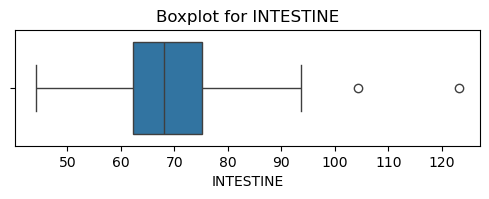

INTESTINE — Outliers detected: 2


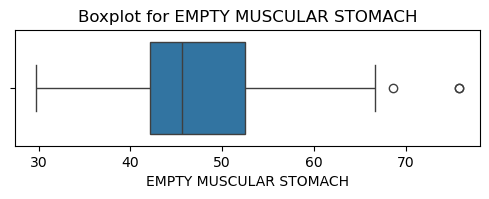

EMPTY MUSCULAR STOMACH — Outliers detected: 3


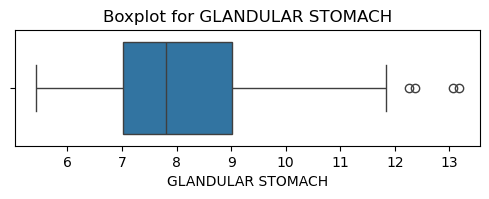

GLANDULAR STOMACH — Outliers detected: 4


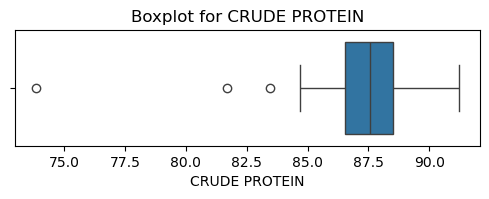

CRUDE PROTEIN — Outliers detected: 3


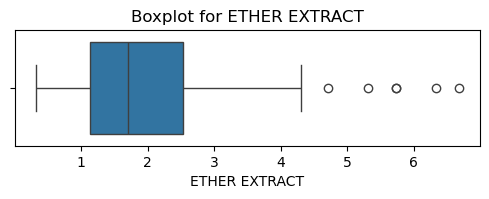

ETHER EXTRACT — Outliers detected: 6


In [11]:
def detect_outliers_iqr(df):
    outlier_info = {}

    for col in df.select_dtypes(include = [np.number] ).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Geting the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_info[col] = {
            'count': outliers.count(),
            'outliers': outliers.values
        }

        # Ploting the boxplots
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], orient='h' )
        plt.title(f"Boxplot for {col}")
        plt.show()

        print(f"{col} — Outliers detected: {outliers.count()}")
    
    return outlier_info

outlier_summary = detect_outliers_iqr(df)

Most columns contain some outliers, but they are few in number and not particularly extreme, so we’ve decided to keep them.
The most notable outliers appear in:

- Breast weight: typically ranges from 200–250, but one value is around 550.

- Thigh weight: usually between 450–650, but there's one outlier close to 200.

- Crude protein: generally falls between 85–95, but there's a value near 72.5.


 Analyzing column: WEIGHT


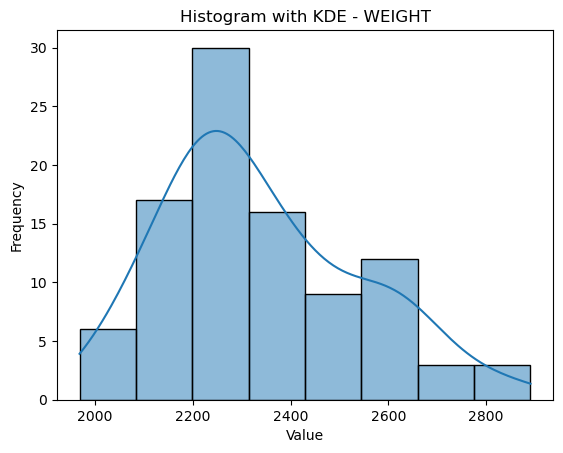

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0100
 Not normally distributed (reject H0)

 Analyzing column: HOT CARCASS WEIGHT


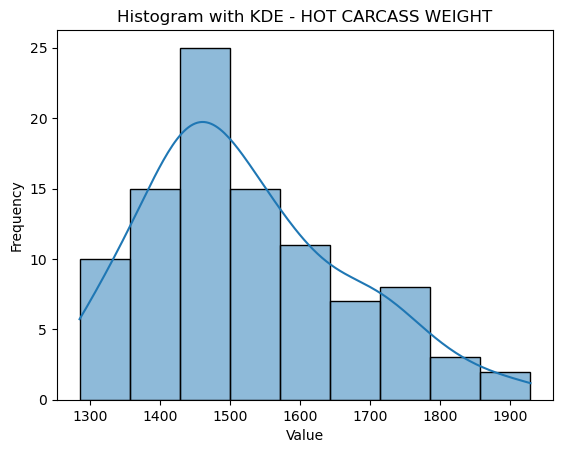

Shapiro-Wilk Test statistic = 0.9611, p-value = 0.0061
 Not normally distributed (reject H0)

 Analyzing column: CARCASS WEIGHT WITH HEAD AND LEGS


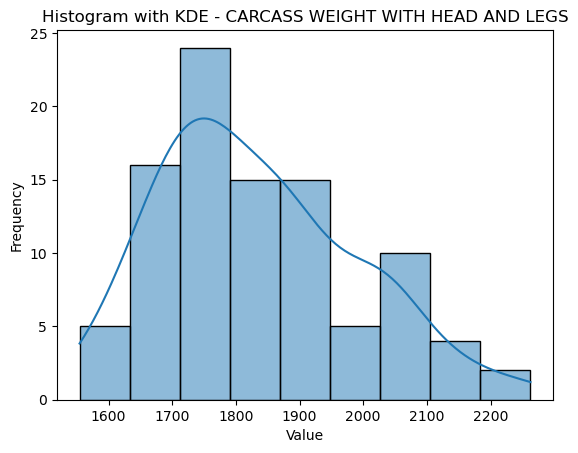

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0099
 Not normally distributed (reject H0)

 Analyzing column: COLD CARCASS WEIGHT


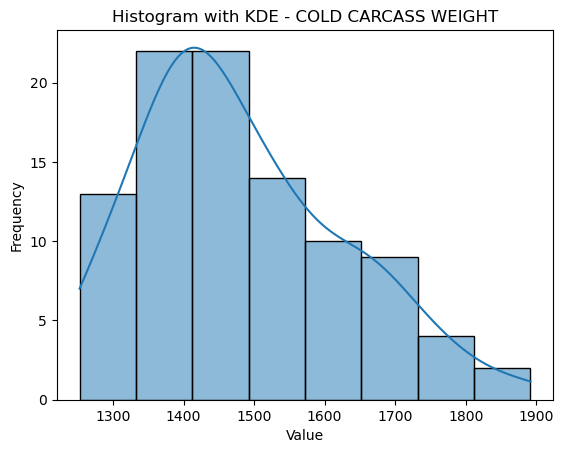

Shapiro-Wilk Test statistic = 0.9577, p-value = 0.0036
 Not normally distributed (reject H0)

 Analyzing column: BREAST WEIGHT (2)


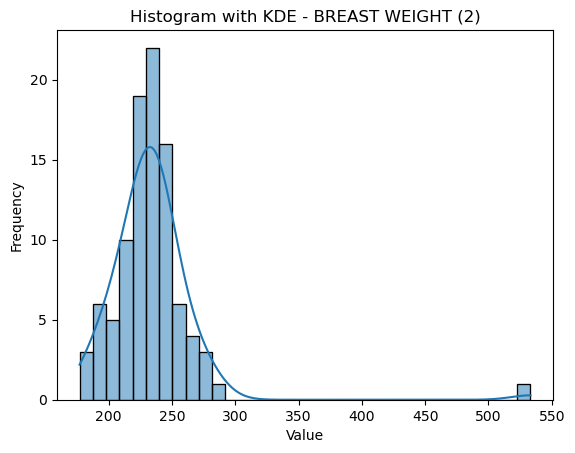

Shapiro-Wilk Test statistic = 0.6057, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: THIGH WEIGHT (2)


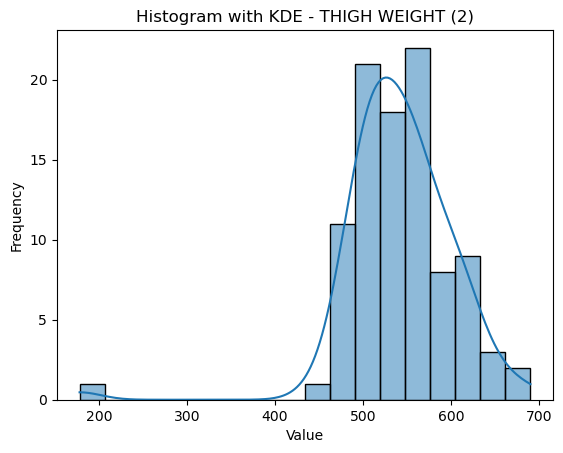

Shapiro-Wilk Test statistic = 0.8492, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: SPLEEN


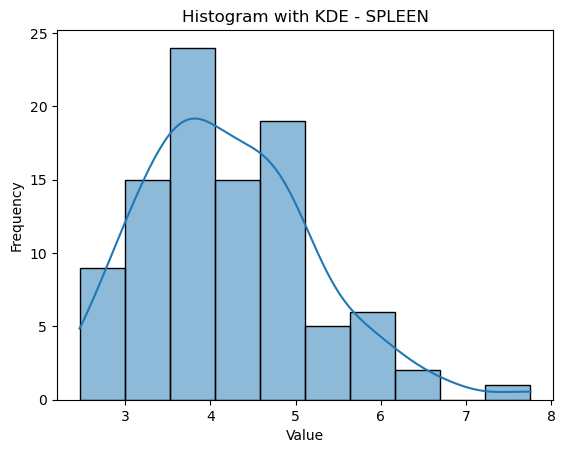

Shapiro-Wilk Test statistic = 0.9657, p-value = 0.0129
 Not normally distributed (reject H0)

 Analyzing column: LIVER


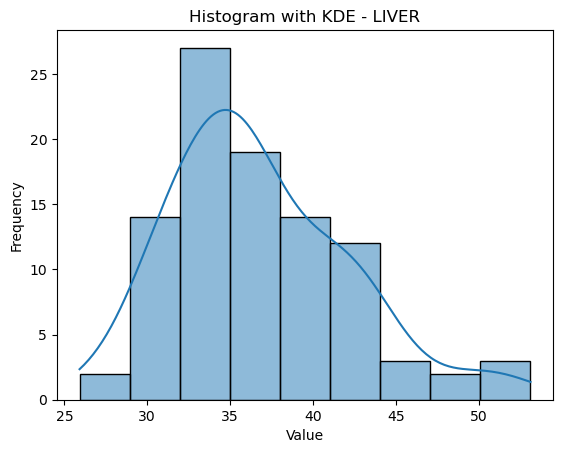

Shapiro-Wilk Test statistic = 0.9633, p-value = 0.0086
 Not normally distributed (reject H0)

 Analyzing column: HEART


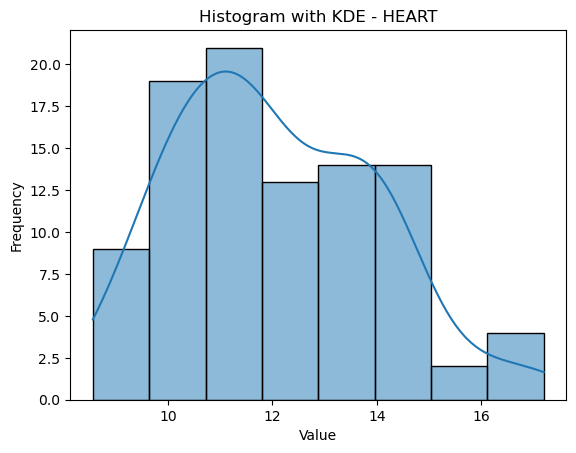

Shapiro-Wilk Test statistic = 0.9730, p-value = 0.0443
 Not normally distributed (reject H0)

 Analyzing column: INTESTINE


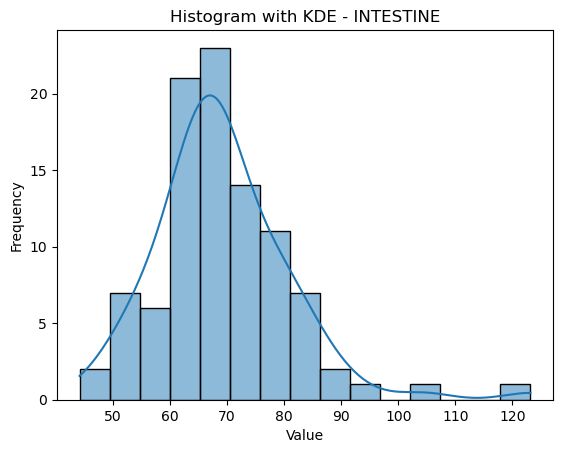

Shapiro-Wilk Test statistic = 0.9302, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: EMPTY MUSCULAR STOMACH


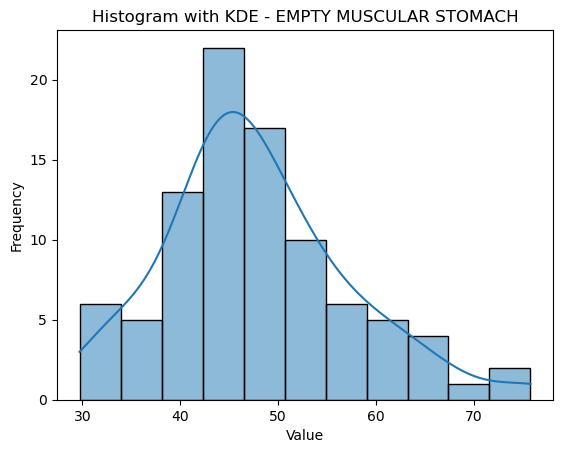

Shapiro-Wilk Test statistic = 0.9656, p-value = 0.0167
 Not normally distributed (reject H0)

 Analyzing column: GLANDULAR STOMACH


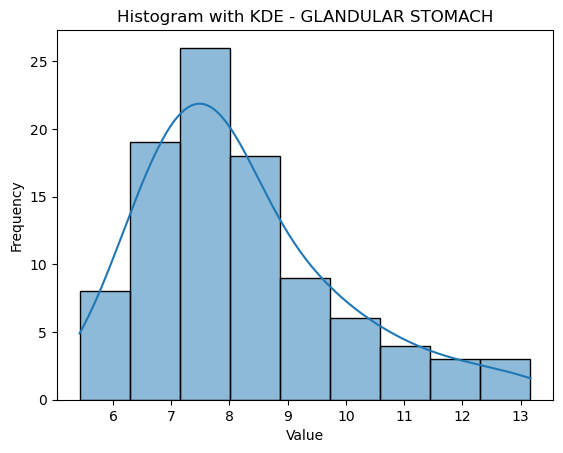

Shapiro-Wilk Test statistic = 0.9303, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: CRUDE PROTEIN


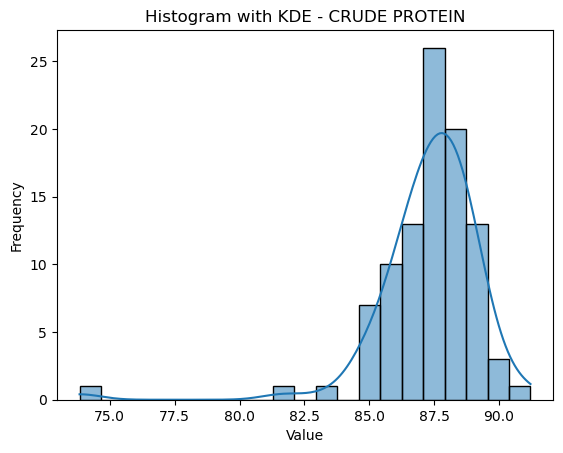

Shapiro-Wilk Test statistic = 0.7674, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: ETHER EXTRACT


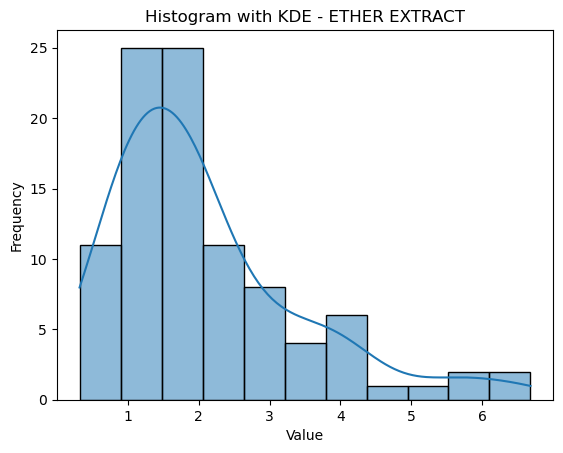

Shapiro-Wilk Test statistic = 0.8674, p-value = 0.0000
 Not normally distributed (reject H0)


In [12]:
# Checking if the data is normally distributed

for column in df.select_dtypes(include=[np.number]).columns:
    print(f"\n Analyzing column: {column}")
    data = df[column].dropna()  

    # Histogram + KDE
    sns.histplot(data, kde=True)
    plt.title(f"Histogram with KDE - {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p > 0.05:
        print(" Likely normal (fail to reject H0)")
    else:
        print(" Not normally distributed (reject H0)")


> All columns in the dataset exhibit non-normal distributions, as confirmed by visual inspection and statistical tests 

<a id="chapter_5"></a>
## Data Preprocessing

In [13]:
# Missing Values
# Calculating the mean
mean_value = df['EMPTY MUSCULAR STOMACH'].mean()

# Replacing the NaNs with the mean
df['EMPTY MUSCULAR STOMACH'] = df['EMPTY MUSCULAR STOMACH'].fillna(mean_value)


In [14]:
# Separating the features from the target
features = df.drop(columns=['CRUDE PROTEIN'])
target = df['CRUDE PROTEIN']

X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32)

<a id="chapter_6"></a>
## Cross-Validation

In [15]:
# Nested Cross Validation
k_outer = 5
k_inner = 3
cv_outer = KFold(n_splits=k_outer, random_state=seed, shuffle=True)
cv_inner = KFold(n_splits=k_inner, random_state=seed, shuffle=True)

We opted to use **nested cross-validation** instead of Monte Carlo because it gives a more confident and reliable estimate of how well the model will perform on new data. The **outer loop** is used to test the model, while the **inner loop** is used for hyperparameter tuning. This setup helps avoid overfitting during tuning and gives a more honest evaluation of the model’s generalization performance.

We chose **5 outer folds** because it gives a good balance between reliable performance estimates and computation time. For the **inner loop**, we used **3 folds** to keep hyperparameter tuning efficient without sacrificing too much accuracy..


<a id="chapter_7"></a>
## Neural Networks

In [16]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation in final layer for regression
        return x


<a id="subchapter_7_2"></a>
### Functions

In [17]:
def rmse_loss(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    return rmse

In [18]:
def nn_fitness(model, data, targets):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        loss = rmse_loss(predictions, targets)
    return loss.item()

In [19]:
def initialize_population(pop_size, input_size, hidden_sizes, output_size):
    population = []
    for _ in range(pop_size):
        model = CustomNN(input_size, hidden_sizes, output_size)
        population.append(model)
    return population

In [20]:
def elitist_select(population, fitness_values, num_parents):
    selected = np.argsort(fitness_values)[:num_parents]
    return [population[i] for i in selected]
    

In [21]:
def elitism(parents, fitness_parents, offspring, fitness_offspring):
    """
    Combine parents and offspring, and select the top individuals
    based on fitness to form the new population.
    """
    combined_population = parents + offspring
    combined_fitness = fitness_parents + fitness_offspring
    
    # Sort by fitness 
    sorted_indices = np.argsort(combined_fitness)
    
    # Select best individuals
    elite = [combined_population[i] for i in sorted_indices[:len(parents)]]
    
    return elite


In [22]:
def tournament_selection(fitness_population, tournament_size):
    i_best = random.sample(range(len(fitness_population)), 1)[0]
    for _ in range(1, tournament_size):
        i_selected = random.sample(range(len(fitness_population)), 1)[0]
        if fitness_population[i_best] > fitness_population[i_selected]:
            i_best = i_selected
    return i_best

In [23]:
def get_best(fitness_population):
    return np.argsort(fitness_population)[0]

def get_worst(fitness_population):
    return (-np.array(fitness_population)).argsort()[0]
    

In [24]:
def crossover(model1, model2):
    """
    Performs parameter crossover between two models.
    """
    child_model = copy.deepcopy(model1)
    with torch.no_grad():
        for p1, p2, pc in zip(model1.parameters(), model2.parameters(), child_model.parameters()):
            # Random binary mask: choose each parameter from parent 1 or parent 2
            mask = torch.rand_like(p1) > 0.5
            pc.copy_(p1 * mask + p2 * (~mask))
    return child_model

In [25]:
def mutate(model, mutation_noise=0.1, node_mutation_rate=0.2):
    """
    Applies random Gaussian noise and potential structural tweaks.
    """
    child_model = copy.deepcopy(model)
    with torch.no_grad():
        for param in child_model.parameters():
            if param.ndim >= 2:  # weights
                noise = mutation_noise * torch.randn_like(param)
                mask = (torch.rand_like(param) < node_mutation_rate).float()
                param.add_(noise * mask)
            else:  # biases
                noise = mutation_noise * torch.randn_like(param)
                mask = (torch.rand_like(param) < node_mutation_rate).float()
                param.add_(noise * mask)
                
    return child_model
    

In [26]:
def evolve(
    population, generations,
    data, targets, data_test, targets_test,
    mutation_rate=0.01, mutation_noise=0.1, node_mutation_rate=0.2,
    population_size=10,
    tournament_size=2
):
    rmse_train_history = []
    rmse_test_history = []
    rmse_train_std_history = []  # New list for std dev of fitness in population
    rmse_train_previous = 1e5

    for generation in tqdm(range(generations)):

        # Population fitness
        fitness_values = [nn_fitness(model, data, targets) for model in population]
        next_population = []

        while len(next_population) < population_size:
            # Select parent 1
            parent_1 = tournament_selection(fitness_population=fitness_values, tournament_size=tournament_size)
            
            # Apply mutation adding offspring to next population
            if random.random() < mutation_rate:
                next_population.append(mutate(copy.deepcopy(population[parent_1]), mutation_noise, node_mutation_rate))
                # print('Mutation')
                # fitness_values = [nn_fitness(model, data, targets) for model in population]
                # print('fitness_values {}'.format(fitness_values))
                # i_elite = get_best(fitness_values)
                # rmse_train = fitness_values[i_elite]
                # print('fitness best pop {}'.format(fitness_values[get_best(fitness_values)]))
                
                # fitness_values = [nn_fitness(model, data, targets) for model in next_population]
                # print('fitness best NEXT pop {}\n'.format(fitness_values[get_best(fitness_values)]))
                # print('fitness_values {}\n'.format(fitness_values))
            else:
                # Otherwise, apply XO adding offspring to next population
                parent_2 = tournament_selection(fitness_population=fitness_values, tournament_size=tournament_size)
                next_population.append(crossover(
                    copy.deepcopy(population[parent_1]), copy.deepcopy(population[parent_2])
                ))

        # Apply elitism and replace population
        fitness_parents = copy.deepcopy(fitness_values)
        fitness_offspring = [nn_fitness(model, data, targets) for model in next_population]
        population = elitism(
            parents=population, fitness_parents=fitness_parents,
            offspring=next_population, fitness_offspring=fitness_offspring
        )

        # Log fitness values of the new population
        fitness_values = [nn_fitness(model, data, targets) for model in population]
        i_elite = get_best(fitness_values)
        rmse_train = fitness_values[i_elite]
        rmse_test = nn_fitness(population[i_elite], data_test, targets_test)

        rmse_train_history.append(rmse_train)
        rmse_test_history.append(rmse_test)
        
        # Calculate and save std deviation of fitness in the population
        rmse_train_std = np.std(fitness_values)
        rmse_train_std_history.append(rmse_train_std)

        rmse_train_previous = rmse_train
        
 
    # Return best model, train history, test history, and train std history
    return population[get_best(fitness_values)], rmse_train_history, rmse_test_history, rmse_train_std_history


In [27]:
def call_genetic(fixed_params, param_grid, seed, outer_fold=None, inner_fold=None, dataset_name=None):
    from itertools import product
    # Unpack param_grid keys and values for grid search
    keys, values = zip(*param_grid.items())

    results = []

    for combo in product(*values):
        dynamic_params = dict(zip(keys, combo))
        full_params = {**fixed_params, **dynamic_params}
        # Initialize population
        population = initialize_population(
            pop_size=full_params['population_size'],
            input_size=full_params['input_size'],
            hidden_sizes=full_params['hidden_sizes'],
            output_size=1
        )
        
 
        # Evolve the population
        best_model, history_train, history_test, history_fit = evolve(
            population=population,
            generations=full_params['generations'],
            data=full_params['X_train'],
            targets=full_params['y_train'],
            data_test=full_params['X_test'],
            targets_test=full_params['y_test'],
            mutation_rate=full_params['mutation_rate'],
            mutation_noise=full_params.get('mutation_noise', 0.1),
            node_mutation_rate=full_params.get('node_mutation_rate', 0.2),
            population_size=full_params['population_size'],
            tournament_size=full_params['tournament_size'],
         
        )
        
        # Evaluate best model on test data
        with torch.no_grad():
            preds = best_model(full_params['X_test'])
            rmse_test = torch.sqrt(torch.nn.MSELoss()(preds.squeeze(), full_params['y_test'])).item()
        
        res = {
            'model': best_model,
            'rmse_train_history': history_train,
            'rmse_test_history': history_test,
            'rmse_train_std_history': history_fit,
            'rmse_test_final': rmse_test,
            'dynamic_params': dynamic_params
        }
        results.append(res)
    
    return results


<a id="subchapter_7_1"></a>
### Problem Instance Definition 

In [28]:
DATASET_NAME = 'Sustavian'

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



In [29]:
# Hyperparameters
input_size = X.shape[1]
hidden_sizes = [5, 5]
output_size = 1
population_size = 500
tournament_size = 3
generations = 100
mutation_rate = 0.5


In [30]:
all_results = []

for outer_fold, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
    print(f"\n=== Outer Fold {outer_fold + 1}/{k_outer} ===")
    
    X_train_outer = X[train_ix]
    y_train_outer = y[train_ix]
    X_test_outer = X[test_ix]
    y_test_outer = y[test_ix]
    
    scaler = RobustScaler()
    X_train_scaled = torch.from_numpy(scaler.fit_transform(X_train_outer)).float()
    X_test_scaled = torch.from_numpy(scaler.transform(X_test_outer)).float()
    y_train_scaled = y_train_outer.clone().detach().float()
    y_test_scaled = y_test_outer.clone().detach().float()

    
    input_size = X_train_scaled.shape[1]
    
    fixed_params = {
        'population_size': population_size, # default, can be overridden in param_grid
        'hidden_sizes': hidden_sizes,
        'generations': generations,
        'tournament_size': tournament_size,
        'input_size': input_size,
        'mutation_rate': mutation_rate,  
        'X_train': None,
        'y_train': None,
        'X_test': None,
        'y_test': None,
    }
    
    inner_results = []
    
    for inner_fold, (inner_train_ix, inner_val_ix) in enumerate(cv_inner.split(X_train_scaled)):
        print(f"  Inner Fold {inner_fold + 1}/{k_inner}")
        
        X_train_inner = X_train_scaled[inner_train_ix]
        y_train_inner = y_train_scaled[inner_train_ix]
        X_val_inner = X_train_scaled[inner_val_ix]
        y_val_inner = y_train_scaled[inner_val_ix]
        
        fixed_params.update({
            'X_train': X_train_inner,
            'y_train': y_train_inner,
            'X_test': X_val_inner,
            'y_test': y_val_inner,
        })
        
        param_grid = {
            'mutation_rate': [0.2, 0.5],
            'population_size': [50, 300]
        }
        
        results_for_inner_fold = call_genetic(
            fixed_params, param_grid,
            seed + outer_fold * 100 + inner_fold,
            outer_fold=outer_fold,
            inner_fold=inner_fold,
            dataset_name=DATASET_NAME
        )
        inner_results.append(results_for_inner_fold)

    all_results.append({
        'outer_fold': outer_fold,
        'test_ix': test_ix,
        'inner_results': inner_results,
        'X_test': X_test_scaled,
        'y_test': y_test_scaled,
    })



=== Outer Fold 1/5 ===
  Inner Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


  Inner Fold 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


  Inner Fold 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]



=== Outer Fold 2/5 ===
  Inner Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


  Inner Fold 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


  Inner Fold 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]



=== Outer Fold 3/5 ===
  Inner Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


  Inner Fold 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


  Inner Fold 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]



=== Outer Fold 4/5 ===
  Inner Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


  Inner Fold 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


  Inner Fold 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]



=== Outer Fold 5/5 ===
  Inner Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


  Inner Fold 2/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


  Inner Fold 3/3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


In [31]:
def results_to_long_df(all_results):
    rows = []
    for outer_result in all_results:
        outer_fold = outer_result['outer_fold']
        for inner_fold_idx, inner_fold_results in enumerate(outer_result['inner_results']):
            for res in inner_fold_results:
                params = res.get('dynamic_params', {})
                rmse_train = res['rmse_train_history']
                rmse_test = res['rmse_test_history']
                rmse_train_std = res.get('rmse_train_std_history', [None]*len(rmse_train))
                
                # Number of generations
                gens = len(rmse_train)
                
                for gen in range(gens):
                    row = {
                        'outer_fold': outer_fold,
                        'inner_fold': inner_fold_idx,
                        'generation': gen,
                        'rmse_train': rmse_train[gen],
                        'rmse_test': rmse_test[gen],
                        'rmse_train_std': rmse_train_std[gen],
                        'rmse_test_final': res['rmse_test_final'],
                    }
                    # Add dynamic params (same for all gens of this result)
                    row.update(params)
                    rows.append(row)
    
    return pd.DataFrame(rows)

In [32]:
all_results


[{'outer_fold': 0,
  'test_ix': array([ 0,  1,  2,  5,  9, 11, 13, 15, 20, 22, 38, 55, 56, 57, 62, 67, 76,
         82, 84, 85]),
  'inner_results': [[{'model': CustomNN(
       (fc1): Linear(in_features=13, out_features=5, bias=True)
       (fc2): Linear(in_features=5, out_features=5, bias=True)
       (fc3): Linear(in_features=5, out_features=1, bias=True)
     ),
     'rmse_train_history': [85.93384552001953,
      85.61876678466797,
      85.01709747314453,
      84.58503723144531,
      84.52996826171875,
      84.2287368774414,
      83.98435974121094,
      83.61589050292969,
      83.18002319335938,
      83.13959503173828,
      82.43305969238281,
      82.32012176513672,
      82.02522277832031,
      81.43016052246094,
      80.70783996582031,
      80.4857177734375,
      80.4857177734375,
      80.39391326904297,
      79.87041473388672,
      79.43705749511719,
      79.30645751953125,
      78.57807159423828,
      78.25466918945312,
      77.72935485839844,
      77.644

In [33]:
df_all = results_to_long_df(all_results)

In [34]:
df_all

outer_fold  inner_fold  generation  rmse_train  rmse_test  \
0              0           0           0   85.933846  86.570557   
1              0           0           1   85.618767  85.626846   
2              0           0           2   85.017097  85.596138   
3              0           0           3   84.585037  84.321541   
4              0           0           4   84.529968  84.455612   
...          ...         ...         ...         ...        ...   
5995           4           2          95    9.525055  11.265454   
5996           4           2          96    9.219110  13.231147   
5997           4           2          97    9.120295  11.680781   
5998           4           2          98    8.841117  11.642180   
5999           4           2          99    8.841117  11.642180   

      rmse_train_std  rmse_test_final  mutation_rate  population_size  
0           0.349255        30.981958            0.2               50  
1           0.253914        30.981958            0.2               50  
2           0.265006        30.981958            0.2               50  
3           0.337148        30.981958            0.2               50  
4           0.273415        30.981958            0.2               50  
...              ...              ...            ...              ...  
5995        0.278945        11.898587            0.5              300  
5996        0.279904        11.898587            0.5              300  
5997        0.280181        11.898587            0.5              300  
5998        0.259662        11.898587            0.5              300  
5999        0.241099        11.898587            0.5              300  

[6000 rows x 9 columns]

In [36]:
df_all['params'] = df_all.apply(
    lambda row: f"mutation={row['mutation_rate']}, pop={row['population_size']}", axis=1
)


<a id="subchapter_7_3"></a>
### Evolution Graphs

<a id="subchapter_7_3_1"></a>
#### Variation of RMSE across Models

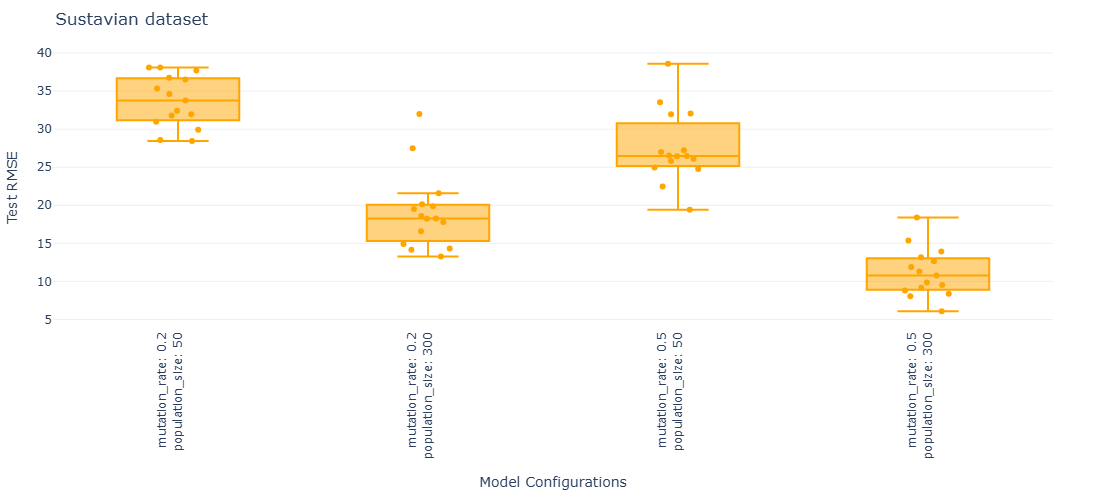

In [35]:
rmse_by_config = defaultdict(list)

# Loop through each outer fold
for outer in all_results:
    # outer['inner_results'] is a list of lists of result dicts
    for inner_fold_results in outer['inner_results']:
        for result in inner_fold_results:
            if not isinstance(result, dict):
                continue  

            # Generate a readable key from dynamic parameters
            key = ''
            for k, v in result.get('dynamic_params', {}).items():
                key += f"{k}: {v} <br /> "
            
            # Append the final RMSE on test set
            rmse_by_config[key].append(result['rmse_test_final'])

# Build the boxplot
fig = go.Figure()
for config, rmse_values in rmse_by_config.items():
    fig.add_trace(go.Box(
        y=rmse_values,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line=dict(color='orange'),
        name=config
    ))

fig.update_layout(
    title=DATASET_NAME + ' dataset',
    xaxis_title='Model Configurations',
    yaxis_title='Test RMSE',
    height=500,
    width=1100,
    xaxis_tickangle=-90,
    yaxis_range=[0, None],
    margin=dict(l=50, r=50, t=50, b=20),
    showlegend=False,
    template='plotly_white'
)

fig.show()


Overall, the test RMSE ranges from 6 to 39. While these values are considerably higher than those observed with GP and GSGP, they are still better than the results obtained with Slim-GSGP. However, a direct comparison should take into account the differences in parameter settings. Among the parameters tested, population size appears to have the most significant impact, as the models with a population of 300 consistently outperform those with a size of 50. Additionally, a lower mutation rate tends to produce more stable results overall.

<a id="subchapter_7_3_2"></a>
#### Train vs Test Fitness 

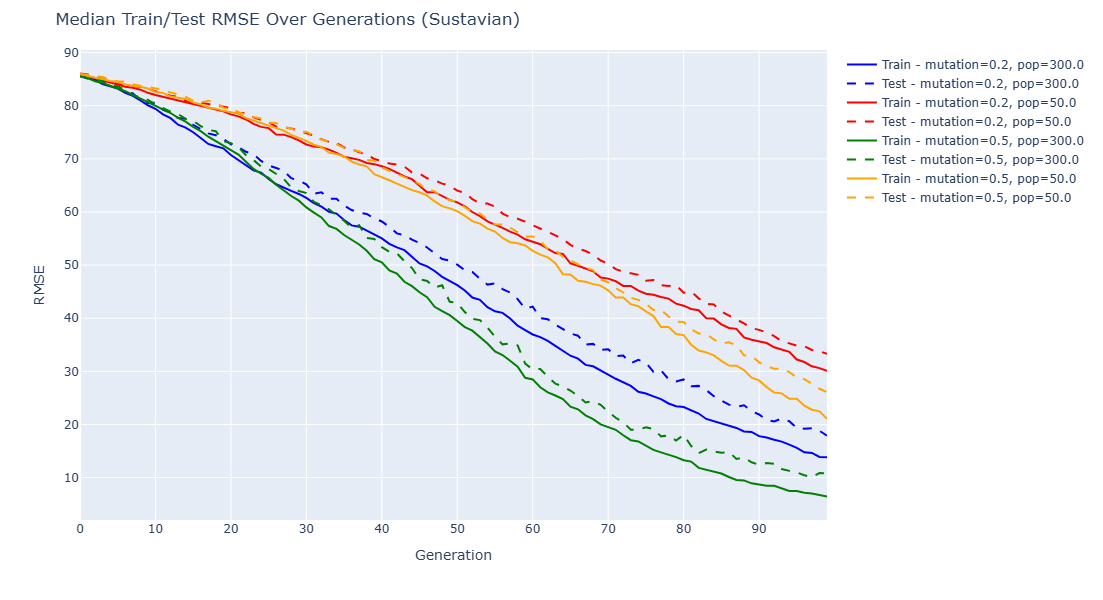

In [38]:
# Group by parameter combo and generation, then calculate median RMSE
median_rmse = df_all.groupby(['params', 'generation'])[['rmse_train', 'rmse_test']].median().reset_index()


fig = go.Figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, (param_key, group) in enumerate(median_rmse.groupby('params')):
    color = colors[i % len(colors)]
    
    # Median Train RMSE over generations
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train'],
        mode='lines',
        name=f'Train - {param_key}',
        line=dict(color=color, dash='solid')
    ))
    
    # Median Test RMSE over generations
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_test'],
        mode='lines',
        name=f'Test - {param_key}',
        line=dict(color=color, dash='dash')
    ))

fig.update_layout(
    title=f'Median Train/Test RMSE Over Generations ({DATASET_NAME})',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    height=600, width=1000,
    margin=dict(t=50),
)

fig.show()

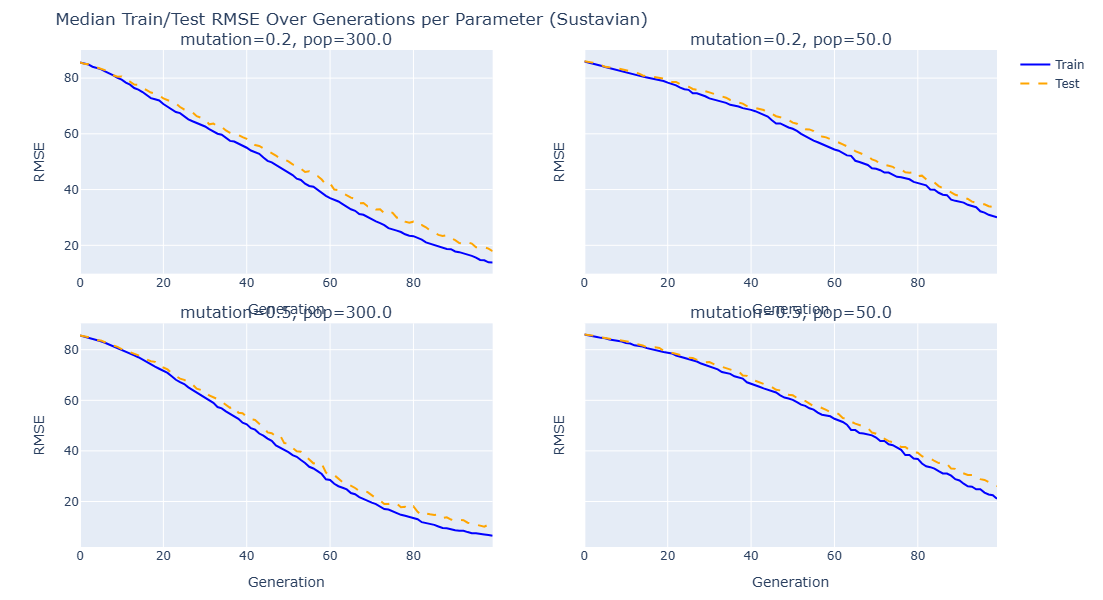

In [39]:
# Get unique parameter sets
param_sets = median_rmse['params'].unique()
n_params = len(param_sets)

# Determine subplot grid size 
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create subplots with shared y-axis but independent x-axes
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=param_sets,
    shared_yaxes=True,
    vertical_spacing=0.1,
)

colors = ['blue', 'red']

for i, param_key in enumerate(param_sets):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    group = median_rmse[median_rmse['params'] == param_key]
    
    # Plot median Train RMSE
    fig.add_trace(
        go.Scatter(
            x=group['generation'],
            y=group['rmse_train'],
            mode='lines',
            name='Train',
            line=dict(color=train_color),
            showlegend=(i == 0)  # Show legend only once
        ),
        row=row, col=col
    )
    
    # Plot median Test RMSE
    fig.add_trace(
        go.Scatter(
            x=group['generation'],
            y=group['rmse_test'],
            mode='lines',
            name='Test',
            line=dict(color=test_color, dash='dash'),
            showlegend=(i == 0)  # Show legend only once
        ),
        row=row, col=col
    )

fig.update_layout(
    height=300 * n_rows,
    width=900,
    title_text=f'Median Train/Test RMSE Over Generations per Parameter ({DATASET_NAME})',
    margin=dict(t=50, b=50),
)

fig.update_xaxes(title_text='Generation')
fig.update_yaxes(title_text='RMSE')

fig.show()



Overall, all configurations show a decreasing RMSE trend, indicating that the models are learning over time. However, as seen before, the performance varies significantly depending on the chosen hyperparameters. A mutation rate of 0.5 consistently leads to lower RMSE values compared to 0.2, suggesting that a higher mutation rate helps explore the search space more effectively. Similarly, larger population sizes (300 vs. 50) tend to perform better, likely due to increased diversity during the search.

Among all tested setups, the combination of mutation=0.5 and population=300 shows the best results, consistently achieving the lowest RMSE on both training and test sets.

That said, overfitting is noticeable across all configurations. The gap between training and test RMSE increases with the number of generations, especially after around iteration 60–70. This shows that the models start to over-specialize on the training data, which harms their generalization ability.

Signs of early convergence are also present, particularly in smaller population settings. These configurations improve rapidly at first but plateau early, indicating they may be getting stuck in local optima due to a lack of diversity. Higher mutation rates help counteract this to some degree by introducing more variation, but they don’t fully eliminate the issue.


<a id="subchapter_7_3_4"></a>
#### Fitness Diversity

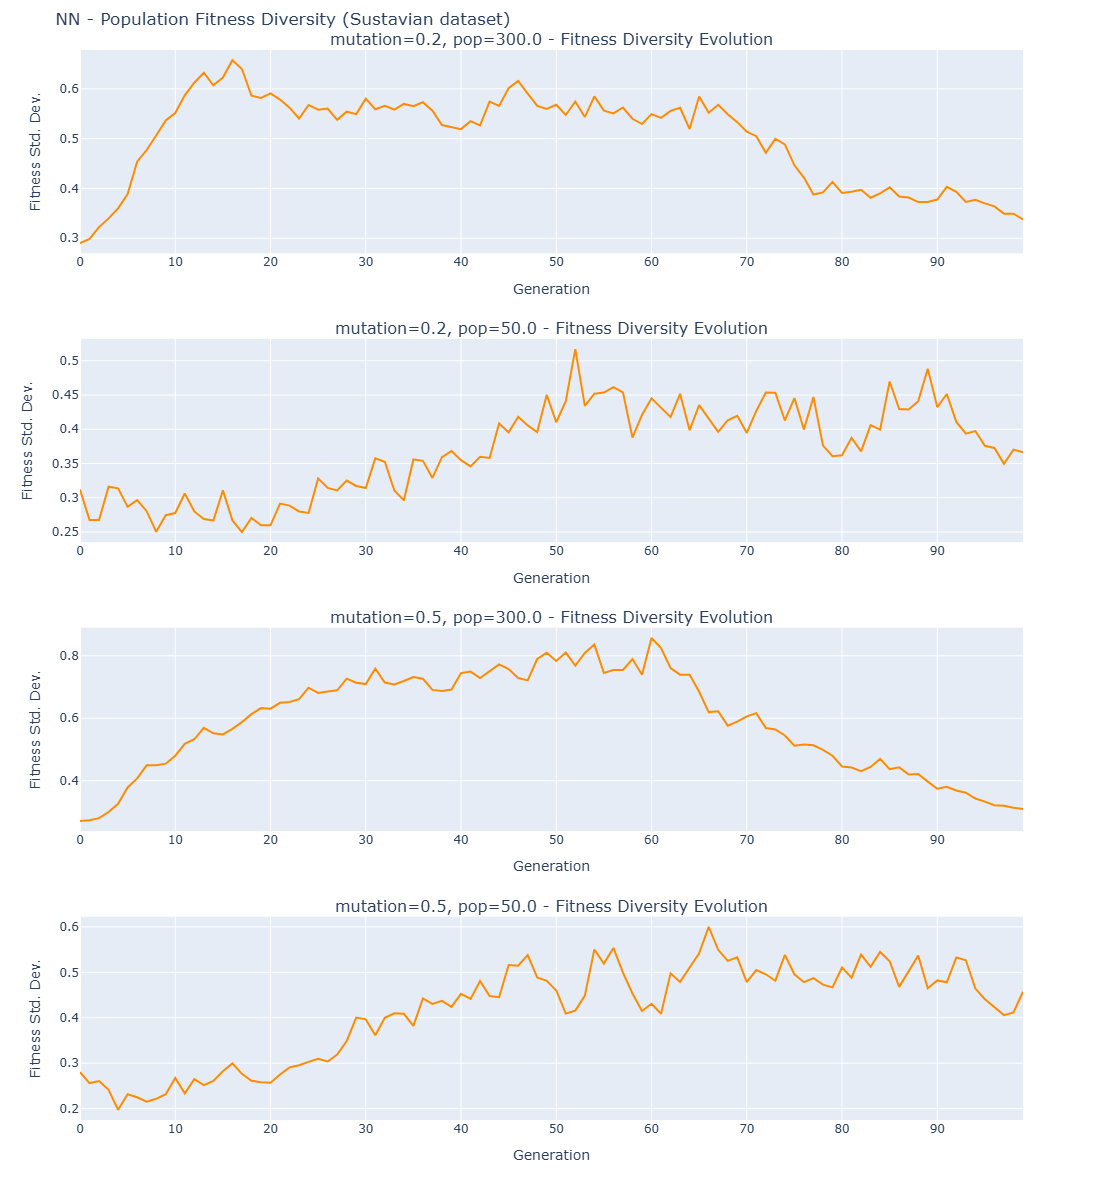

In [40]:


# Compute median fitness diversity per generation and param
fitness_diversity = df_all.groupby(['params', 'generation'])['rmse_train_std'].median().reset_index()

# Unique parameter sets
unique_params = fitness_diversity['params'].unique()
n_params = len(unique_params)

# Create subplots: 1 row per param
fig = make_subplots(
    rows=n_params, cols=1,
    subplot_titles=[f'{param} - Fitness Diversity Evolution' for param in unique_params],
    vertical_spacing=0.08
)

for i, param in enumerate(unique_params):
    group = fitness_diversity[fitness_diversity['params'] == param]
    
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train_std'],
        mode='lines',
        name=f'{param}',
        line=dict(color='darkorange'),
        showlegend=False
    ), row=i+1, col=1)

# Layout
fig.update_layout(
    height=300 * n_params,
    width=800,
    title_text=f'NN - Population Fitness Diversity ({DATASET_NAME} dataset)',
    margin=dict(t=50),
    yaxis_range=[0, None]
)

# Axes labels
for row in range(1, n_params + 1):
    fig.update_xaxes(title_text='Generation', row=row, col=1)
    fig.update_yaxes(title_text='Fitness Std. Dev.', row=row, col=1)

fig.show()



The fitness diversity plots show that larger populations (pop=300) start with low diversity, then spike early before slowly declining, with a sharp drop after generation 70–80. This suggests decent exploration at the start, followed by convergence. Smaller populations (pop=50) maintain lower and noisier diversity throughout, struggling to explore effectively and converging early.

Higher mutation (0.5) clearly helps keep diversity up for longer, especially with pop=300. This delays convergence and gives the algorithm more room to explore. Lower mutation (0.2) leads to quicker drops in diversity, which lines up with worse RMSE results.

Smaller populations show clear signs of early convergence as diversity doesn’t build up enough, and they plateau fast. Larger populations manage to hold on to diversity longer, allowing better results. Mutation helps too, but can’t fully fix early convergence when the population is too small.

#### Summary: 
**Overfitting** <br>
All setups show slight signs of overfitting, with the train-test RMSE gap widening after 60–70 iterations. 

**Early Convergence** <br>
Smaller populations converge early, with low and unstable diversity throughout. Even larger populations eventually drop in diversity after generation 70–80, showing convergence. High mutation delays this but doesn’t fully prevent it.

In [90]:
best_model = None
best_rmse = float('inf')

for outer_result in all_results:
    for inner_fold_results in outer_result['inner_results']:
        for model_info in inner_fold_results:
            last_rmse = model_info['rmse_test_history'][-1]
            if last_rmse < best_rmse:
                best_rmse = last_rmse
                best_model = model_info['model']



<a id="chapter_8"></a>
### To Evaluate

We will use these evaluation metrics, MAE, MSE, and correlation coefficients, to measure the performance of each algorithm. After calculating these metrics, we will apply statistical tests to determine whether the observed differences in performance are statistically significant, following the approach recommended by Rainio et al. (2024).


In [91]:
# Converting PyTorch tensors to NumPy arrays
y_pred = best_model(X_test_scaled).detach().numpy()
y_true = y_test_outer.detach().numpy()

In [88]:
# Computing Spearman's rank correlation
spearman_corr_nn, _ = spearmanr(y_true_np, y_pred_np)

print("Spearman’s correlation (rs):", spearman_corr_nn)

Spearman’s correlation (rs): 0.12188728258101349


In [89]:
# Computing MAE and MSE
mae_nn = mean_absolute_error(y_true_np, y_pred_np)
mse_nn = mean_squared_error(y_true_np, y_pred_np)

print("MAE:", mae_nn)
print("MSE:", mse_nn)


MAE: 7.656613826751709
MSE: 131.01768493652344
